# Drift Diffusion Model {#sec-ddm}

**Prerequisiti**

- Leggere *A practical introduction to using the drift diffusion model of decision-making in cognitive
psychology, neuroscience, and health sciences* di @myers2022practical.
- Leggere *Face masks influence emotion judgments of facial expressions: a drift–diffusion model* di @williams2023face.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [8]:
# Importazioni dalla libreria standard
import os

# Importazioni di librerie di terze parti
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from cmdstanpy import CmdStanModel
import statsmodels.api as sm

# Configurazione
seed = sum(map(ord, "ddm"))  # Genera un seme basato sulla somma dei valori ASCII della stringa "linear_algebra"
rng = np.random.default_rng(seed=seed)  # Crea un generatore di numeri casuali con il seme specificato
sns.set_theme(palette="colorblind")  # Imposta il tema di Seaborn per grafici accessibili ai daltonici
az.style.use("arviz-darkgrid")  # Imposta lo stile dei grafici di ArviZ
%config InlineBackend.figure_format = "retina"  # Migliora la risoluzione dei grafici inline

# Definizione delle directory
home_directory = os.path.expanduser("~")  # Ottiene la directory home dell'utente
project_directory = f"{home_directory}/_repositories/psicometria"  # Definisce la directory del progetto

# Stampa la directory del progetto per verificarla
print(f"Directory del progetto: {project_directory}")

Directory del progetto: /Users/corradocaudek/_repositories/psicometria


## Introduzione

I meccanismi cognitivi sono sistemi dinamici complessi che richiedono modelli in grado di catturare le intricate dinamiche dei loro componenti. Per comprendere appieno la struttura dei dati empirici umani, è necessario un approccio che tenga conto di queste complessità. Una metodologia efficace per formalizzare matematicamente tali sistemi dinamici è trattarli come processi generativi stocastici, i quali producono dati con dipendenze temporali, ovvero serie temporali.

La natura intrinsecamente non lineare della maggior parte dei sistemi complessi si riflette in queste serie temporali. Anziché mostrare semplici fluttuazioni attorno a una media stabile con varianza fissa, esse tendono a manifestarsi come random walk eterogenei, evidenziando la complessità sottostante.

In questo contesto, il Drift Diffusion Model (DDM) emerge come un'applicazione rilevante di questo quadro teorico [@myers2022practical]. Originariamente sviluppato da Ratcliff nel 1978 e successivamente raffinato, il DDM si propone di descrivere il processo decisionale rapido tra due alternative di risposta (DDM; Ratcliff, 1978; Ratcliff e McKoon, 2008; Ratcliff et al., 2016). La sua crescente popolarità negli ultimi anni è attribuibile sia allo sviluppo di algoritmi che lo implementano, sia a una letteratura sempre più vasta che ne dimostra l'utilità nel comprendere processi cognitivi altrimenti difficili da descrivere con metodi tradizionali di analisi dei dati.

Il processo decisionale, o *decision making*, rappresenta un campo di studio fondamentale nella psicologia cognitiva e nelle neuroscienze cognitive. Questo processo complesso comprende diversi stadi: dal riconoscimento delle caratteristiche della situazione, alla considerazione di molteplici alternative di risposta, fino alla selezione ed esecuzione di una risposta, all'osservazione dei risultati e all'adattamento del comportamento basato su questi esiti.

L'importanza di studiare il decision making risiede nelle sue implicazioni pratiche. Qualsiasi compromissione in una delle fasi del processo decisionale può avere conseguenze significative nella vita quotidiana. Ad esempio, problemi nell'adattamento possono portare gli individui a privilegiare benefici a breve termine a discapito della salute a lungo termine, come nel caso di comportamenti additivi. Inoltre, alterazioni nel processo decisionale sono state associate a una vasta gamma di disturbi psicologici, dalla depressione e i disturbi d'ansia, ai disturbi di personalità borderline, fino alla suicidalità.

In conclusione, l'approccio del DDM offre un potente strumento per esplorare e comprendere i meccanismi cognitivi sottostanti al processo decisionale. La sua applicazione non solo arricchisce la nostra comprensione teorica, ma ha anche implicazioni pratiche significative per la diagnosi e il trattamento di vari disturbi psicologici.

## Panoramica del modello di diffusione del drift (DDM)

Nelle attività di decisione rapida in psicologia cognitiva, ai partecipanti viene richiesto di scegliere rapidamente tra due o più risposte in competizione. Esempi tipici includono il compito di decisione lessicale (dove si preme un tasto se lo stimolo è una parola e un altro se non lo è), il compito di Stroop (in cui si preme un tasto corrispondente al colore dell'inchiostro di una parola, ignorando il contenuto semantico della parola stessa) e il compito dei flanker saccadici (che richiede di muovere l'occhio nella direzione indicata da uno stimolo centrale, ignorando le direzioni dei flanker).

In questi compiti, anche partecipanti ben addestrati mostrano un compromesso tra velocità e accuratezza: essi possono incrementare l'accuratezza a scapito di tempi di risposta più lenti (e quindi maggiormente deliberati), oppure optare per decisioni rapide che risultano più suscettibili a errori (Schouten e Bekker, 1967; Wickelgren, 1977). Questo trade-off tra velocità e accuratezza sembra essere almeno parzialmente sotto il controllo conscio, poiché i partecipanti possono modulare le loro prestazioni in base alle istruzioni ricevute per enfatizzare la velocità o l'accuratezza (Ratcliff e Rouder, 1998; Voss et al., 2004; Milosavljevic et al., 2010; Katsimpokis et al., 2020). Questa flessibilità comportamentale complica l'interpretazione dei dati, poiché le differenze nei tempi di risposta tra gruppi possono riflettere meccanismi cognitivi sottostanti distinti (Voss et al., 2013). Ad esempio, due gruppi di pazienti potrebbero entrambi avere tempi di reazione medi più lenti rispetto a un gruppo di controllo sano, ma mentre in un gruppo ciò potrebbe riflettere una strategia decisionale più cauta, nell'altro potrebbe indicare un rallentamento dovuto alla patologia. È quindi fondamentale disporre di metodi di analisi che considerino non solo la velocità e l'accuratezza, ma anche l'interazione tra queste due variabili.

Per affrontare queste complessità, un approccio complementare all'analisi dei dati comportamentali osservati è l'uso di modelli computazionali che mirano a inferire i parametri di modelli che descrivono processi cognitivi latenti. Questi parametri, quando combinati, sono in grado di riprodurre la distribuzione osservata dei tempi di reazione (RT) e delle accuratezze.

Il modello di diffusione del drift (Drift Diffusion Model, DDM), descritto inizialmente da Ratcliff e colleghi (Ratcliff, 1978; Ratcliff e McKoon, 2008; Ratcliff et al., 2016), è un esempio prominente di una classe più ampia di modelli denominati "modelli di accumulazione dell'evidenza". Tali modelli concettualizzano il processo decisionale come un accumulo di evidenza a favore di una delle risposte possibili, fino al raggiungimento di una soglia decisionale che innesca la risposta corrispondente. Questi modelli, noti anche come modelli di campionamento sequenziale, suggeriscono che il sistema nervoso acquisisca ripetutamente frammenti di informazione (campioni) dall'ambiente in modo sequenziale, fino a raggiungere una soglia di evidenza sufficiente per prendere una decisione. Il compromesso tra velocità e accuratezza rappresenta quindi un punto di equilibrio che determina quando interrompere il campionamento e agire sulla base delle informazioni accumulate.

Come tutti i modelli computazionali, il DDM è formalizzato attraverso un insieme di equazioni matematiche che includono diversi parametri, ciascuno dei quali può essere assegnato a valori differenti. Un modo intuitivo di concepire i parametri è considerarli come regolatori (o sliders) di un sistema stereo, ognuno dei quali controlla un aspetto diverso del suono (ad esempio, alti, bassi, volume) e che possono essere regolati singolarmente per ottenere l'effetto desiderato complessivo. Analogamente, i parametri in un modello di accumulazione dell'evidenza regolano aspetti come la velocità di accumulazione dell'evidenza, un bias intrinseco verso una delle risposte, e la tendenza a privilegiare la velocità rispetto all'accuratezza. La regolazione di ciascuno di questi parametri influenza il comportamento del modello.

Nelle sezioni seguenti, descriveremo i passaggi principali nel processo di modellizzazione. Inizialmente, forniremo una descrizione generale del DDM, dei suoi parametri e del suo utilizzo in psicologia cognitiva. Successivamente, presenteremo un esempio concreto di applicazione del DDM in un semplice compito di decisione a due scelte, illustrando il processo di fitting del modello per stimare i valori dei parametri per un singolo partecipante, seguito dalla validazione del modello. Infine, discuteremo come riportare i risultati del modello e sottoporli ad analisi statistica.

## Parametri nel modello di diffusione del drift (DDM)

Il modello di diffusione del drift (DDM) parte dall'assunto che il tempo di reazione (RT) in ogni prova, definito come il tempo che intercorre dall'inizio dello stimolo fino all'esecuzione della risposta motoria, possa essere scomposto in tre componenti: il tempo necessario per il sistema nervoso per rilevare o codificare lo stimolo (spesso indicato come Te), il tempo per raggiungere una decisione su come rispondere a quello stimolo (Td) e il tempo richiesto per eseguire la risposta motoria scelta (Tr). Pertanto, in una data prova, il tempo di reazione osservato è la somma di queste tre componenti: RT = Te + Td + Tr.

Sebbene in teoria sia possibile misurare separatamente Te e Tr, normalmente il tempo di codifica e di risposta vengono combinati in un unico parametro che rappresenta il tempo di non-decisione (Ter), ovvero la parte del RT che avviene indipendentemente dal processo decisionale Td. Con questa semplificazione, l’equazione diventa RT = Ter + Td. I valori tipici di Ter variano tra 0.1 e 0.5 secondi, in parte a seconda della complessità degli stimoli e delle risposte motorie specifiche coinvolte (ad esempio, le persone possono generalmente eseguire saccadi più velocemente rispetto alla pressione di un tasto). Si assume solitamente che Ter possa differire tra individui, ma rimanga relativamente costante tra le prove per un singolo individuo che esegue un determinato compito.

L'altra componente del RT è il tempo di decisione (Td), che è il tempo necessario per prendere una decisione (dopo che lo stimolo è stato codificato, ma prima che venga eseguita la risposta scelta). In una singola prova, l'informazione rumorosa viene accumulata nel tempo mentre il processo si muove lungo un corridoio delimitato dalle due possibili risposte. Man mano che si accumulano maggiori informazioni, l'evidenza a favore di una risposta spinge il processo decisionale più vicino al confine corrispondente. Quando uno dei confini viene raggiunto, viene selezionata la risposta corrispondente, e il tempo per raggiungere quel confine definisce il tempo di decisione Td in quella prova.

![Drift Diffusion Model.](../../figures/ddm_fig.png){ width=60% }

Il modello DDM prevede che il processo decisionale inizi da un punto sulla y definito da un parametro che denota un punto di partenza relativo (z) che varia da 0 (asse inferiore) a 1 (asse superiore). Se z = 0.5, il punto di partenza è equidistante dai due confini. Tuttavia, se z si avvicina a 1 (o 0), il processo decisionale inizia vicino al confine superiore (o inferiore) in ogni prova, il che significa che è necessaria meno informazione per raggiungere quel confine e iniziare la risposta corrispondente. Il punto di partenza z riflette quindi un bias di risposta a favore di una o dell'altra risposta.

Il processo decisionale nel DDM è considerato rumoroso, il che riflette la presenza di input sensoriali rumorosi, variazioni stocastiche nel tasso di scarica neuronale nei centri decisionali del cervello e anche fluttuazioni momentanee nell'attenzione. Questo rumore implica che lo stesso stimolo potrebbe non generare lo stesso tempo di decisione o addirittura la stessa risposta ogni volta che si verifica, portando a variazioni nel RT e nell'accuratezza delle risposte tra le prove.

Nel DDM, il tasso medio al quale l'evidenza si accumula verso il confine corretto è definito da un parametro che rappresenta il *tasso di drift* (*drift rate*) (d). Il tasso di drift è una misura della velocità di elaborazione delle informazioni, che può variare a seconda della difficoltà del compito. Per compiti facili con stimoli altamente discriminabili, ci dovrebbe essere un alto tasso di drift (pendenza ripida su o giù), e l'evidenza dovrebbe accumularsi rapidamente e in modo affidabile verso il confine corretto, risultando in tempi di reazione rapidi e alta accuratezza. Per compiti più difficili o stimoli più ambigui, il tasso di drift può essere più basso (meno ripido), il che significa che l'accumulo di evidenza è più lento e rumoroso, risultando in tempi di reazione più lenti e variabili.

Riassumendo, i parametri del DDM si mappano su diversi processi cognitivi: impostazioni di velocità-accuratezza (separazione del confine $a$), bias di risposta (punto di partenza $z$), velocità di elaborazione delle informazioni (tasso di drift $d$) e tempo di non-decisione ($Ter$). Questi parametri sono talvolta chiamati "parametri liberi", nel senso che possono assumere diversi valori liberamente, e proprio come le manopole di uno stereo, cambiare ciascun parametro influenza il comportamento del DDM.

Per esempio, in un compito in cui il soggetto è istruito a eseguire una risposta r1 il più rapidamente possibile ogni volta che viene mostrato uno stimolo s1, ma una risposta diversa r2 ogni volta che viene mostrato uno stimolo s2, l'aumento del punto di partenza ($z$) avvicinerà il punto di partenza al confine superiore, rendendo più facile (e veloce) decidere a favore di r2 in ogni prova. Questo potrebbe creare un bias di risposta preponderante per r2 se, ad esempio, le risposte r2 sono molto più frequenti o altamente ricompensate nel compito.

Riducendo la separazione del confine ($a$), entrambe le risposte diventerebbero più veloci, ma aumenterebbe anche il tasso di errore, perché il rumore potrebbe facilmente spingere il processo decisionale oltre uno dei confini. Una separazione del confine ridotta potrebbe verificarsi se, ad esempio, il soggetto fosse stato istruito a rispondere rapidamente, anche a scapito della precisione. Al contrario, aumentare a avrebbe l'effetto opposto, aumentando la cautela nelle risposte e producendo tempi di reazione più lenti.

Aumentare il tasso di drift per un tipo di stimolo comporterebbe un accumulo di evidenza più rapido in quelle prove, mentre diminuirlo comporterebbe un accumulo più lento. I tassi di drift sono tipicamente più lenti in condizioni di compiti più difficili, con minore discriminabilità degli stimoli o in presenza di stimoli distraenti.

Infine, aumentare o diminuire il tempo di non-decisione Ter influenzerebbe il tempo di reazione complessivo, senza altrimenti influenzare il processo decisionale. Ad esempio, pazienti con disfunzioni motorie potrebbero avere un Ter aumentato (e un RT complessivo maggiore), indipendentemente dalle considerazioni decisionali.

In sintesi, i valori dei parametri del DDM Ter, $a$, $z$ e $d$ interagiscono per influenzare le prestazioni complessive del compito, compresi sia l'accuratezza che il tempo di reazione.

## Il Meccanismo di Accumulo dell'Evidenza

Dal punto di vista formale, il Drift Diffusion Model (DDM) è un modello matematico utilizzato per descrivere il processo decisionale in situazioni di scelta binaria. Questo modello rappresenta il processo decisionale attraverso il meccanismo di accumulo dell'evidenza $Z_t$.

Nel DDM, l'accumulo dell'evidenza $Z_t$ è modellato come un moto browniano con drift $\delta$ e volatilità $\alpha$. Matematicamente, è espresso dalla formula: 

$$
Z_t = \delta t + \alpha B_t,
$$ {#eq-wiener}

dove $B_t$ è un moto browniano standard o processo di Wiener.

Ciascun termine di questa formula rappresenta un aspetto fondamentale del processo decisionale:

1. **$Z_t$ - Processo di accumulo dell'evidenza:**  
   $Z_t$ rappresenta l'evidenza accumulata fino al tempo $t$ verso una delle due possibili decisioni. Quando $Z_t$ raggiunge una delle soglie decisionali, viene presa una decisione.

2. **$\delta$ - Drift rate (tasso di drift):**  
   $\delta$ indica la velocità media di accumulo dell'evidenza. È un parametro deterministico che rappresenta la tendenza media dell'evidenza verso una decisione. Un $\delta$ positivo implica una tendenza verso una delle opzioni (ad esempio, quella "a favore"), mentre un $\delta$ negativo suggerisce una tendenza verso l'altra opzione (ad esempio, quella "contro"). Il drift rate determina quindi la direzione e la velocità media con cui l'evidenza si accumula.

3. **$t$ - Tempo:**  
   $t$ rappresenta il tempo trascorso dall'inizio del processo decisionale. Nel contesto della formula, $t$ viene moltiplicato per il drift rate $\delta$, indicando come l'evidenza si accumula linearmente nel tempo in base alla velocità e direzione del drift.

4. **$\alpha$ - Volatilità:**  
   $\alpha$ rappresenta l'intensità delle fluttuazioni casuali nel processo di accumulo dell'evidenza. Questo parametro misura la quantità di variabilità o "rumore" nel processo decisionale. Un valore di $\alpha$ più elevato implica maggiori fluttuazioni casuali nel percorso dell'evidenza accumulata, rendendo il processo decisionale più imprevedibile.

5. **$B_t$ - Moto browniano standard (processo di Wiener):**  
   $B_t$ rappresenta un moto browniano standard, noto anche come processo di Wiener, che è un modello matematico per descrivere un movimento casuale nel tempo. È un processo stocastico con media zero e varianza proporzionale al tempo $t$. Nel DDM, $B_t$ rappresenta le fluttuazioni casuali dell'evidenza accumulata che si verificano mentre l'individuo elabora le informazioni per prendere una decisione.

In sintesi, la formula $Z_t = \delta t + \alpha B_t$ descrive come l'evidenza accumulata ($Z_t$) si evolve nel tempo come somma di un componente deterministico ($\delta t$), che rappresenta la tendenza media dell'accumulo di evidenza, e un componente stocastico ($\alpha B_t$), che rappresenta la variabilità casuale o rumore nel processo decisionale. Questa combinazione di elementi permette al DDM di modellare accuratamente come le decisioni binarie vengono prese nel tempo in presenza di incertezza e variabilità.

Nel DDM, il processo di accumulo dell'evidenza si muove in modo casuale verso l'alto o verso il basso fino a raggiungere una delle soglie decisionali prestabilite. Queste soglie rappresentano i punti critici che determinano la decisione finale: quando l'evidenza accumulata $Z_t$ raggiunge una soglia, viene presa una decisione a favore dell'alternativa associata a quella soglia. Generalmente, ci sono due soglie, una superiore e una inferiore, che corrispondono alle due possibili decisioni. La scelta finale è determinata dal raggiungimento di una di queste soglie, indicando la selezione dell'agente tra le due alternative disponibili.

## Il Moto Browniano

Per comprendere meglio il funzionamento del DDM, è utile chiarire il concetto di moto browniano (ovvero, la componente $B_t$ nell'@eq-wiener), noto anche come processo di Wiener.

Il moto browniano è un tipo di processo stocastico che descrive il comportamento casuale di una particella in movimento. È uno dei modelli più semplici e utilizzati per rappresentare l'evoluzione temporale di variabili che cambiano in modo incerto e imprevedibile nel tempo.

Il processo di Wiener ha diverse proprietà che lo rendono utile per modellare fenomeni casuali:

1. **Inizio a zero**: Il processo inizia da un punto di partenza, spesso zero, cioè $W(0) = 0$.

2. **Incrementi indipendenti**: Gli incrementi del processo sono indipendenti tra loro. Ciò significa che il cambiamento del valore del processo in un intervallo di tempo non dipende dal cambiamento in un altro intervallo di tempo non sovrapposto.

3. **Incrementi normali**: Gli incrementi del processo di Wiener su un intervallo di tempo $t$ sono distribuiti normalmente (secondo una distribuzione gaussiana) con media 0 e varianza proporzionale a $t$. Formalmente, se $t_2 > t_1$, allora $W(t_2) - W(t_1) \sim N(0, t_2 - t_1)$.

4. **Continuità**: Il processo di Wiener è continuo, senza salti improvvisi, il che implica che il percorso del processo nel tempo è una funzione continua.

Nel contesto del Drift Diffusion Model (DDM), il processo di Wiener è utilizzato per rappresentare le fluttuazioni casuali nel processo di accumulo dell'evidenza verso una delle due possibili decisioni.

- **Evidenza accumulata**: Nel DDM, l'accumulo di evidenza per una decisione è considerato come un processo che si evolve nel tempo. Questo accumulo è influenzato da un termine deterministico (il drift rate, $v$) e da un termine stocastico (il rumore, modellato dal processo di Wiener).

- **Termine deterministico (drift rate, $v$)**: Rappresenta la velocità media di accumulo dell'evidenza verso una delle decisioni. Un drift rate positivo indica una tendenza verso una decisione "a favore", mentre un drift rate negativo indica una tendenza verso una decisione "contro".

- **Termine stocastico (rumore)**: Rappresenta la variabilità casuale nell'accumulo dell'evidenza. Questo rumore è modellato come un processo di Wiener, il che significa che l'evidenza può fluttuare casualmente mentre si accumula nel tempo.

### Simulazione di un Processo di Wiener

Per simulare un processo di Wiener, possiamo utilizzare un semplice modello matematico che genera incrementi casuali normali a ogni passo temporale. Nel contesto del DDM, l'evidenza accumulata $Z(t)$ a un tempo $t$ può essere rappresentata come:

$$
Z(t + \Delta t) = Z(t) + v \Delta t + s \Delta W,
$$

dove:

- $\Delta t$ è un piccolo intervallo di tempo.
- $v$ è il drift rate, che rappresenta la velocità media con cui l'evidenza si accumula in una direzione preferita.
- $s$ è la deviazione standard del rumore, che misura l'intensità delle fluttuazioni casuali nel processo di accumulo dell'evidenza.
- $\Delta W \sim N(0, \Delta t)$ è un incremento casuale del processo di Wiener, distribuito normalmente con media 0 e varianza $\Delta t$. Questo termine rappresenta il rumore stocastico che influenza il processo decisionale.

Un esempio intuitivo per comprendere il funzionamento di questi elementi è il seguente: immagina di camminare su una linea dritta su una superficie ghiacciata. Se cammini dritto, il drift rate $v$ rappresenta il tuo intento di muoverti verso una direzione specifica. Tuttavia, poiché la superficie è scivolosa, ogni passo che fai è influenzato dalla casualità (il processo di Wiener), facendoti scivolare in modo imprevedibile in diverse direzioni. La tua posizione finale dipenderà sia dalla tua intenzione di camminare dritto (drift rate) sia dalla casualità dei tuoi scivolamenti (rumore stocastico).

In conclusione, nel DDM, il processo di Wiener rappresenta la componente casuale del processo decisionale, mentre il drift rate rappresenta la componente sistematica o deterministica. Le soglie decisionali determinano i criteri per la decisione finale. Insieme, questi elementi permettono di modellare il processo di accumulazione dell'evidenza che porta alla decisione finale e determina il tempo di reazione in situazioni di scelta binaria.

## Stima dei Parametri

Sono stati proposti diversi metodi per stimare i parametri del DDM. Un approccio iniziale per la stima dei parametri del DDM è il metodo del χ² (ad esempio, Ratcliff e Tuerlinckx, 2002), che confronta un istogramma delle distribuzioni dei tempi di reazione (RT) nei dati empirici con quelli previsti dal modello sotto un dato insieme di valori dei parametri.

I principali vantaggi del metodo χ² sono la velocità computazionale e la relativa robustezza agli RT anomali. Tuttavia, il metodo χ² richiede un gran numero di prove per produrre una stima affidabile (ad esempio, almeno 500 prove) e può risultare problematico se ci sono relativamente poche risposte errate (ad esempio, meno di 12 prove in qualsiasi intervallo quantile; Voss et al., 2015). Per queste ragioni, l'approccio del χ² per l'adattamento dei parametri è diventato meno utilizzato negli ultimi anni, poiché sono stati resi disponibili altri metodi e la potenza di calcolo è aumentata.

Un metodo popolare per stimare i parametri del DDM utilizza la stima di massima verosimiglianza (MLE) per generare stime per ciascun parametro. Formalmente, la MLE cerca di trovare un insieme di valori dei parametri che, insieme, massimizzino la probabilità che il risultato del modello corrisponda ai dati empirici su tutte le prove. Gli approcci MLE sono stati utilizzati con successo in un gran numero di studi sul DDM e possono essere utilizzati anche quando sono disponibili relativamente poche prove (ad esempio, meno di 50) per ciascun partecipante (Lerche et al., 2017). Tuttavia, la MLE può essere molto sensibile agli RT anomali (soprattutto RT molto rapidi), quindi è necessario prestare molta attenzione alla pulizia dei dati. Inoltre, gli algoritmi MLE sono vulnerabili ai minimi locali, il che significa che possono convergere su un insieme di valori dei parametri in cui nessuna piccola perturbazione può migliorare ulteriormente la LLE, anche se questa potrebbe non essere la soluzione ottimale. Per questo motivo, i ricercatori che usano questo metodo eseguono la procedura MLE più volte, con diversi valori di partenza, per assicurarsi che la stessa soluzione venga trovata ogni volta.

Recentemente, sono stati proposti diversi approcci bayesiani per stimare i valori dei parametri del DDM. Questi metodi, partono da stime iniziali (cioè "distribuzioni a priori") su valori ragionevoli per ciascun parametro, e tali stime vengono aggiornate iterativamente per produrre le "distribuzioni posteriori" per quei parametri. Il calcolo delle distribuzioni posteriori è estremamente intensivo dal punto di vista computazionale e la soluzione diretta è generalmente intrattabile (non esiste un modo matematico noto per calcolare direttamente i posteriori dai priori e dai dati). Invece, si cercano soluzioni approssimate usando i metodi Markov Chain Monte Carlo (MCMC). Gli approcci bayesiani al DDM possono essere più robusti nel recupero dei parametri del modello rispetto ad altri metodi, come la MLE e il metodo χ², quando è disponibile un numero limitato di prove (Wiecki et al., 2013). Gli approcci bayesiani forniscono non solo stime dei parametri (media o mediana delle distribuzioni posteriori), ma quantificano anche l'incertezza in queste stime (deviazione standard o intervallo di confidenza al 95% delle distribuzioni posteriori).

I metodi sopra descritti per stimare i parametri del DDM presuppongono che i parametri siano adattati ai dati di ciascun partecipante in modo indipendente. Un approccio alternativo è la modellizzazione gerarchica, che affronta le differenze individuali mentre raccoglie informazioni tra individui per generare stime dei parametri a livello di gruppo (Vandekerckhove et al., 2011; Wiecki et al., 2013; Johnson et al., 2017). Gli approcci gerarchici possono essere particolarmente utili quando la variabilità all'interno del gruppo è molto inferiore rispetto alla variabilità tra gruppi, o quando è disponibile solo un numero ridotto di prove per ciascun partecipante. 

## Simulazione

L'obiettivo di questa sezione è esaminare un campione di dati generato in conformità con il modello DDM. Nella simulazione, i parametri utilizzati per generare i dati secondo il DDM sono noti. Successivamente, ci proponiamo di inferire questi parametri a partire dai dati simulati. Per raggiungere questo scopo, utilizzeremo un approccio bayesiano implementato in Stan.

Iniziamo generando i dati secondo il DDM utilizzando i seguenti parametri:

- Drift rate: 2.0
- Threshold separation (separazione delle soglie): 1.0
- Non-decision time (tempo di non decisione): 0.3
- Starting point (punto di partenza) $z$: 0.5

In [62]:
def simulate_ddm(v, a, t, z, n_trials):
    """
    Simulate data from a simplified Drift Diffusion Model.

    Parameters:
    v (float): Drift rate
    a (float): Boundary separation
    t (float): Non-decision time
    z (float): Starting point (a priori bias)
    n_trials (int): Number of trials to simulate

    Returns:
    tuple: (RTs, responses)
    """
    RTs = []
    responses = []

    for _ in range(n_trials):
        x = z * a  # starting point
        time = 0

        while True:
            x += v * 0.001 + np.random.normal(
                0, np.sqrt(0.001)
            )  # update every millisecond
            time += 0.001

            if x <= 0 or x >= a:
                break

        RT = time + t  # add non-decision time
        response = 1 if x >= a else 0

        RTs.append(RT)
        responses.append(response)

    return np.array(RTs), np.array(responses)

In [63]:
# Parameters
v_true = 2.0
a_true = 1.0
t_true = 0.3
z_true = 0.5
n_trials = 1000

RTs, responses = simulate_ddm(v_true, a_true, t_true, z_true, n_trials)

print(f"Mean RT: {np.mean(RTs):.3f}")
print(f"Proportion of upper boundary responses: {np.mean(responses):.3f}")

Mean RT: 0.501
Proportion of upper boundary responses: 0.888


Creiamo un istogramma dei tempi di reazione (RT).

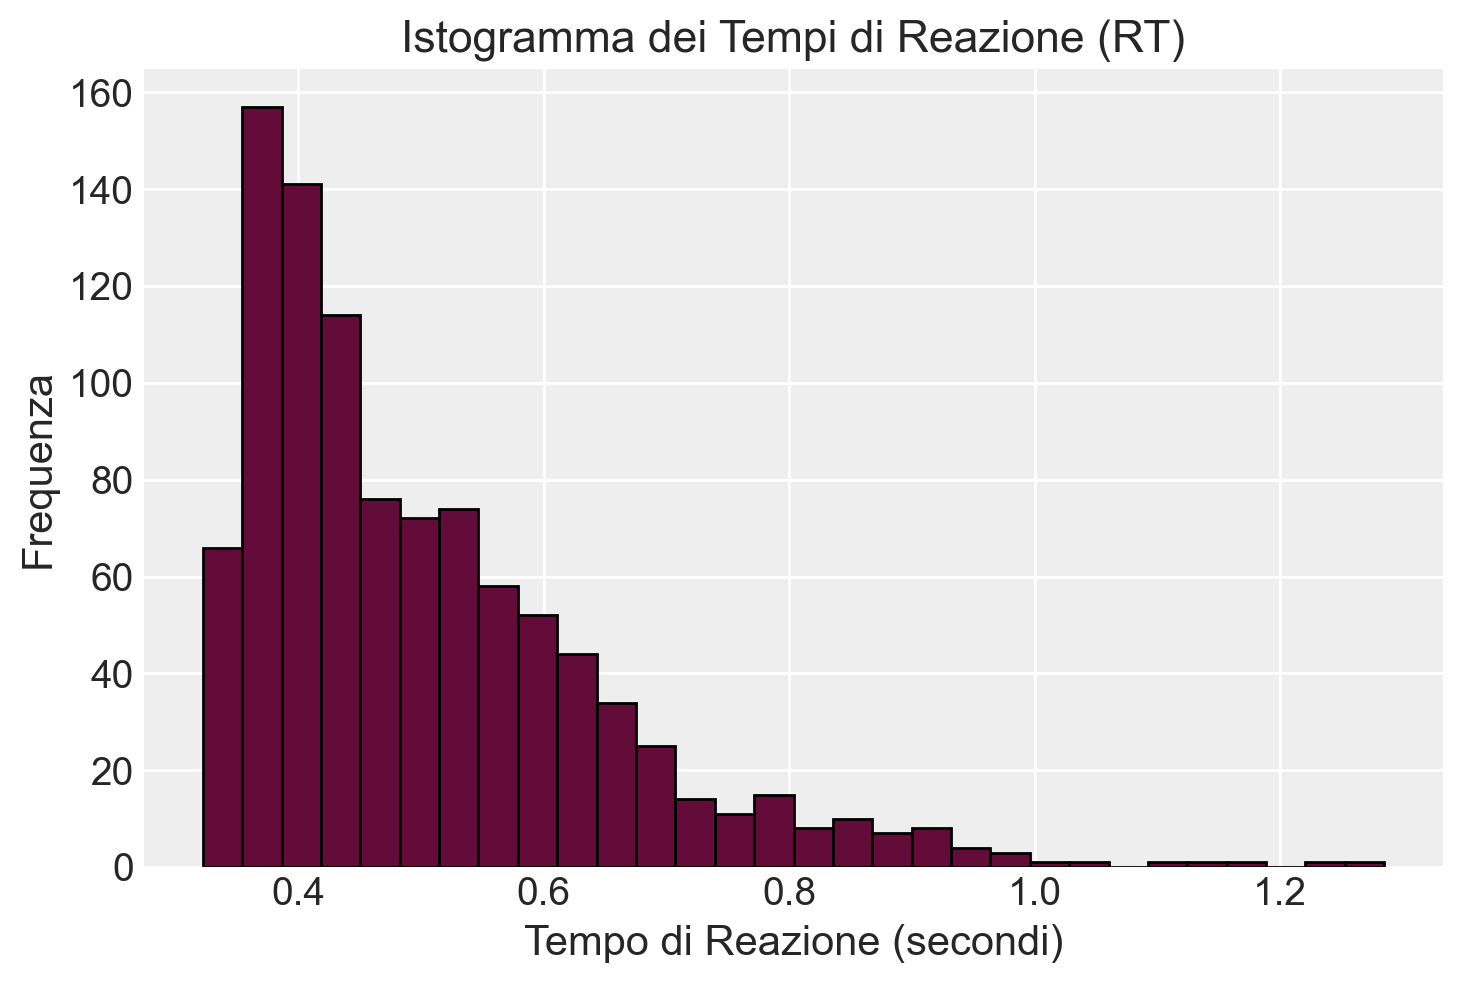

In [65]:
plt.hist(RTs, bins=30, edgecolor="black")
plt.title("Istogramma dei Tempi di Reazione (RT)")
plt.xlabel("Tempo di Reazione (secondi)")
plt.ylabel("Frequenza")
plt.show()

Importiamo e compiliamo il codice Stan, che utilizzeremo per generare le distribuzioni a posteriori dei parametri del DDM, basandoci su distribuzioni a priori debolmente informative.

In [66]:
stan_file = os.path.join(
    project_directory, "stan", "ddm_wiener_model.stan"
)

model = CmdStanModel(stan_file=stan_file)
print(model.code())

functions {
  real wiener_rng(real alpha, real tau, real beta, real delta) {
    real dt = 0.0001;
    real x = alpha * beta;
    real t = 0;
    while (x > 0 && x < alpha) {
      x += delta * dt + sqrt(dt) * normal_rng(0, 1);
      t += dt;
    }
    return t + tau;
  }
}
data {
  int<lower=1> N; // number of trials
  array[N] real<lower=0> rt; // response times
  array[N] int<lower=0, upper=1> resp; // responses (0 or 1)
}
parameters {
  real<lower=0, upper=10> v; // drift rate
  real<lower=0.1, upper=5> a; // boundary separation
  real<lower=0.001, upper=min(rt)> t; // non-decision time
  real<lower=0.1, upper=0.9> z; // starting point
}
model {
  // Priors
  v ~ normal(2, 1) T[0, 10];
  a ~ normal(1, 0.5) T[0.1, 5];
  t ~ normal(0.3, 0.1) T[0.001, min(rt)];
  z ~ beta(5, 5);
  
  // Likelihood
  for (i in 1 : N) {
    if (rt[i] > t) {
      if (resp[i] == 1) {
        target += wiener_lpdf(rt[i] | a, t, z, v);
      } else {
        target += wiener_lpdf(rt[i] | a, t, 1 - z, -v);


La *likelihood* (verosimiglianza) nel modello Stan specifica la probabilità dei dati osservati dato un insieme di parametri. Nel contesto del DDM, la likelihood è costruita sulla base della distribuzione di probabilità dei tempi di reazione (RT) per una risposta corretta o errata, dato un set di parametri del modello (drift rate $v$, boundary separation $a$, non-decision time $t$, e starting point $z$).

Nel blocco `model`, la likelihood è costruita utilizzando un ciclo `for` per ogni trial (prova) nei dati. Per ogni prova, la likelihood tiene conto delle seguenti considerazioni:

1. Condizioni su $\text{rt}[i] > t$:
   - Prima di tutto, il modello verifica se il tempo di reazione osservato (`rt[i]`) è maggiore del tempo di non-decisione (`t`). Questo perché il tempo di reazione non può essere inferiore al tempo di non-decisione: se lo fosse, sarebbe un tempo di reazione impossibile.
   - Se $\text{rt}[i] > t$, il codice procede a calcolare la verosimiglianza; altrimenti, impone una penalità molto forte (`-1e10`) per quei dati, indicando che tali osservazioni sono impossibili o estremamente improbabili. Questa penalità è così grande da garantire che tali eventi non contribuiscano alla log-verosimiglianza complessiva, influenzando negativamente l'adattamento del modello se venissero accettati.

2. Calcolo della Likelihood per le Risposte:
   - Risposte corrette (`resp[i] == 1`):
     - Se la risposta è corretta (`resp[i] == 1`), viene utilizzata la distribuzione dei tempi di reazione del DDM per una risposta corretta, data dai parametri $a$, $t$, $z$, e $v$. 
     - La funzione `wiener_lpdf(rt[i] | a, t, z, v)` calcola il log della densità di probabilità per il tempo di reazione osservato (`rt[i]`) sotto queste condizioni.
   
   - Risposte errate (`resp[i] == 0`):
     - Se la risposta è errata (`resp[i] == 0`), viene utilizzata la distribuzione dei tempi di reazione del DDM per una risposta errata. In questo caso, il modello inverte il drift rate a $-v$ e considera la posizione di partenza opposta $(1 - z)$.
     - La funzione `wiener_lpdf(rt[i] | a, t, 1 - z, -v)` calcola il log della densità di probabilità per il tempo di reazione osservato (`rt[i]`) sotto queste condizioni.

Questo approccio consente di stimare i parametri del modello che meglio spiegano i dati osservati, tenendo conto delle distribuzioni stocastiche che descrivono il processo decisionale nel contesto di un compito di scelta binaria.

Nel blocco `parameters` e `model` del codice, vediamo le seguenti distribuzioni a priori.

1. `v ~ normal(2, 1) T[0, 10]`:
   Il drift rate \(v\) ha una distribuzione a priori normale con media 2 e deviazione standard 1, troncata tra 0 e 10. Questo prior riflette l'assunzione che il drift rate tipico sia intorno a 2, con una moderata incertezza, ed è limitato a valori non negativi e ragionevolmente grandi (fino a 10) per rappresentare le condizioni realistiche di un processo decisionale umano.

2. `a ~ normal(1, 0.5) T[0.1, 5]`:
   La separazione delle soglie \(a\) ha una distribuzione a priori normale con media 1 e deviazione standard 0.5, troncata tra 0.1 e 5. Questo prior suggerisce che, normalmente, i confini sono vicini a 1, con una certa variazione consentita. La troncatura assicura che il parametro rimanga in un intervallo ragionevole, evitando valori troppo piccoli o troppo grandi che non sarebbero realistici nei modelli di decisione umana.

3. `t ~ normal(0.3, 0.1) T[0.001, min(rt)]`:
   Il tempo di non-decisione \(t\) ha una distribuzione a priori normale con media 0.3 e deviazione standard 0.1, troncata tra 0.001 e il valore minimo dei tempi di reazione osservati `min(rt)`. Questo prior riflette l'idea che il tempo di non-decisione (che rappresenta il tempo impiegato per percepire e avviare una risposta senza prendere una decisione) è solitamente intorno a 0.3 secondi, ma con una moderata variabilità. La troncatura inferiore (0.001) impedisce che il tempo di non-decisione diventi irrealisticamente piccolo, mentre la troncatura superiore (min(rt)) garantisce che \(t\) sia sempre inferiore a qualsiasi tempo di reazione registrato.

4. `z ~ beta(5, 5)`: 
   Il punto di partenza \(z\) ha una distribuzione a priori beta con parametri 5 e 5, limitata tra 0.1 e 0.9. Questo prior beta è simmetrico intorno a 0.5, suggerendo una preferenza iniziale che il punto di partenza sia centrato tra le due soglie decisionali, ma con una certa variabilità consentita. La troncatura tra 0.1 e 0.9 evita punti di partenza troppo vicini alle soglie, il che rappresenterebbe un bias estremo non tipico nelle decisioni umane.

In sintesi, questi priors debolmente informativi assicurano che le stime dei parametri siano basate sui dati osservati, ma anche che rimangano in un intervallo realistico. 

Creiamo un dizionario con i dati nel formato richiesto da Stan.

In [67]:
# Create the data dictionary for the Stan models
stan_data = {
    "N": len(RTs),  # Number of trials
    "rt": RTs,  # Reaction times
    "resp": responses,  # Accuracy
}

Eseguiamo il campionamento.

In [68]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

07:05:19 - cmdstanpy - INFO - CmdStan start processing
07:05:19 - cmdstanpy - INFO - Chain [1] start processing
07:05:19 - cmdstanpy - INFO - Chain [2] start processing
07:05:19 - cmdstanpy - INFO - Chain [3] start processing
07:05:19 - cmdstanpy - INFO - Chain [4] start processing
07:06:15 - cmdstanpy - INFO - Chain [3] done processing
07:06:16 - cmdstanpy - INFO - Chain [2] done processing
07:06:17 - cmdstanpy - INFO - Chain [1] done processing
07:06:18 - cmdstanpy - INFO - Chain [4] done processing


In [69]:
# Run diagnostics and print results
diagnostic_info = fit.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpeh6g91py/ddm_wiener_modelhxa8924m/ddm_wiener_model-20240829070519_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpeh6g91py/ddm_wiener_modelhxa8924m/ddm_wiener_model-20240829070519_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpeh6g91py/ddm_wiener_modelhxa8924m/ddm_wiener_model-20240829070519_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpeh6g91py/ddm_wiener_modelhxa8924m/ddm_wiener_model-20240829070519_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Esaminiamo le distribuzioni a posteriori dei parametri del DDM.

In [70]:
fit_az = az.from_cmdstanpy(posterior=fit)
az.summary(fit_az, var_names=["v", "a", "t", "z"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.93,0.10,1.75,2.11,0.0,0.0,3858.53,4325.16,1.0
a,1.03,0.02,0.99,1.07,0.0,0.0,4116.55,5011.74,1.0
t,0.30,0.00,0.30,0.31,0.0,0.0,3233.80,4430.35,1.0
z,0.52,0.01,0.49,0.54,0.0,0.0,3782.31,4288.92,1.0


Da notare che l'approccio bayesiano è riuscito a fornire stime accurate dei parametri utilizzati per la simulazione dei dati, con un livello di incertezza relativamente basso. Questo è stato possibile grazie all'uso di un campione di dati piuttosto ampio (N = 1000), che rappresenta le prove di un singolo soggetto.

Abbiamo utilizzato il metodo Leave-One-Out (LOO) cross-validation per valutare il modello. I valori k di Pareto sono stati calcolati per identificare eventuali influenze indebite di osservazioni anomale sui risultati:

In [26]:
loo_results = az.loo(fit_az)
print(loo_results)

Computed from 8000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   404.07    34.22
p_loo        3.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Tutte le osservazioni hanno valori k di Pareto ben sotto la soglia di 0.5, il che significa che non ci sono prove di influenze indebite da parte di osservazioni anomale sui risultati. I risultati indicano dunque che non ci sono evidenze di influenze eccessive da parte di osservazioni anomale nel campione, confermando che il modello è stabile e le stime sono affidabili.

## L'influenza delle mascherine sulle valutazioni delle emozioni 

Per esercizio, esaminiamo lo studio di @williams2023face, che ha analizzato l'influenza delle mascherine facciali sul riconoscimento delle emozioni. Sebbene sia noto che le mascherine rallentano la diffusione del SARS-CoV-2, non è ancora chiaro in che modo possano influenzare le interazioni sociali. Una possibile conseguenza è che le mascherine possano modificare il modo in cui le persone comunicano le emozioni attraverso le espressioni facciali. Nel loro studio, @williams2023face indagano in che misura e in che modo le mascherine influenzano la comunicazione delle emozioni facciali, utilizzando il modello di drift-diffusion (DDM).

![Ai partecipanti venivano mostrate espressioni facciali che rappresentavano sei emozioni (rabbia, disgusto, paura, felicità, tristezza, sorpresa) con tre diversi tipi di "maschere facciali" (inferiore, nessuna, superiore) -- figura tratta da @williams2023face.](../../figures/williams_stimuli.png){ width=90% }

I risultati evidenziano che, sebbene le persone siano ancora in grado di comunicare efficacemente le emozioni indossando mascherine, emergono anche delle difficoltà legate al riconoscimento delle emozioni stesse. Utilizzando il DDM, @williams2023face dimostrano che l'accumulo di evidenze, come meccanismo sottostante, può essere influenzato dall'uso delle mascherine, e che in situazioni in cui il tempo è un fattore critico, le mascherine potrebbero aumentare il rischio di incomprensioni.

I risultati dello studio di @williams2023face mostrano che i partecipanti sono riusciti a identificare le espressioni facciali più frequentemente rispetto al caso anche con le mascherine. Tuttavia, i partecipanti erano meno propensi e più lenti a riconoscere correttamente le espressioni quando le mascherine coprivano parte del volto e accumulavano evidenze sulle emozioni in modo più lento rispetto a quando non indossavano le mascherine.

Per gli scopi di questo tutorial, utilizzeremo il modello Stan descritto in precedenza per analizzare il riconoscimento di una specifica emozione, considerando se il volto è coperto o meno da una maschera visiva. L'emozione che prenderemo in esame è la rabbia. La maschera visiva, quando presente, copre la parte superiore del volto. In queste condizioni, @williams2023face hanno riscontrato un drift rate inferiore quando i partecipanti dovevano riconoscere l'emozione da stimoli parzialmente mascherati.

Nel loro studio originale, @williams2023face hanno coinvolto 228 soggetti. Per analizzare questi dati sarebbe quindi opportuno utilizzare un modello bayesiano gerarchico. Tuttavia, per semplicità, in questo tutorial utilizzeremo un sotto-campione casuale di 30 soggetti nelle due condizioni descritte. Inoltre, considereremo questi dati come provenienti da un unico "super-soggetto", trascurando le differenze individuali.

Iniziamo importando i dati relativi alla condizione in cui il volto arrabbiato è parzialmente coperto da una maschera visiva.

In [97]:
df_angry_upper = pd.read_csv("../../data/williams_2023_angry_upper.csv")
df_angry_upper.head()

,subj_idx,trial,response,rt,resp
0,2b3o5c2c6ntefnb,35,0,1.720625,1
1,2b3o5c2c6ntefnb,65,0,2.227810,1
2,2b3o5c2c6ntefnb,69,0,0.584445,1
3,2b3o5c2c6ntefnb,73,0,0.805395,1
4,2b3o5c2c6ntefnb,91,0,1.181125,1


Importiamo i dati relativi alla condizione in cui il volto arrabbiato non è coperto da una maschera visiva.

In [98]:
df_angry_baseline = pd.read_csv("../../data/williams_2023_angry_baseline.csv")
df_angry_baseline.head()

,subj_idx,trial,response,rt,resp
0,2b3o5c2c6ntefnb,18,0,0.771650,1
1,2b3o5c2c6ntefnb,47,0,0.626895,1
2,2b3o5c2c6ntefnb,77,0,0.744640,1
3,2b3o5c2c6ntefnb,93,0,0.612550,1
4,2b3o5c2c6ntefnb,98,0,0.639810,1


Generiamo un dizionario con i dati e eseguiamo il campionamento per i giudizi nei quali il volto arrabbiato non è coperto da una maschera visiva.

In [99]:
stan_data_baseline = {
    "N": len(df_angry_baseline["rt"]),  # Number of trials
    "rt": df_angry_baseline["rt"],  # Reaction times
    "resp": df_angry_baseline["resp"],  # Accuracy
}

In [100]:
fit_baseline = model.sample(
    data=stan_data_baseline,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

08:53:25 - cmdstanpy - INFO - CmdStan start processing
08:53:25 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [2] start processing
08:53:25 - cmdstanpy - INFO - Chain [3] start processing
08:53:25 - cmdstanpy - INFO - Chain [4] start processing
08:55:13 - cmdstanpy - INFO - Chain [2] done processing
08:55:13 - cmdstanpy - INFO - Chain [4] done processing
08:55:13 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [3] done processing


Esaminiamo la distribuzione a posteriori dei parametri del DDM.

In [101]:
fit_baseline_az = az.from_cmdstanpy(posterior=fit_baseline)
az.summary(fit_baseline_az, var_names=["v", "a", "t", "z"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.58,0.05,0.48,0.67,0.0,0.0,4298.51,4116.92,1.0
a,2.04,0.04,1.97,2.11,0.0,0.0,5596.90,5367.25,1.0
t,0.02,0.01,0.01,0.04,0.0,0.0,5183.94,2552.18,1.0
z,0.44,0.01,0.41,0.46,0.0,0.0,4684.97,4835.42,1.0


Generiamo un dizionario con i dati e eseguiamo il campionamento per i giudizi nei quali il volto arrabbiato è parzialmente coperto da una maschera visiva.

In [102]:
stan_data_upper = {
    "N": len(df_angry_upper["rt"]),  # Number of trials
    "rt": df_angry_upper["rt"],  # Reaction times
    "resp": df_angry_upper["resp"],  # Accuracy
}

In [103]:
fit_upper = model.sample(
    data=stan_data_upper,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

08:55:40 - cmdstanpy - INFO - CmdStan start processing
08:55:40 - cmdstanpy - INFO - Chain [1] start processing
08:55:40 - cmdstanpy - INFO - Chain [2] start processing
08:55:40 - cmdstanpy - INFO - Chain [3] start processing
08:55:40 - cmdstanpy - INFO - Chain [4] start processing
08:57:22 - cmdstanpy - INFO - Chain [3] done processing
08:57:22 - cmdstanpy - INFO - Chain [1] done processing
08:57:23 - cmdstanpy - INFO - Chain [4] done processing
08:57:24 - cmdstanpy - INFO - Chain [2] done processing


Esaminiamo la distribuzione a posteriori dei parametri del DDM.

In [104]:
fit_upper_az = az.from_cmdstanpy(posterior=fit_upper)
az.summary(fit_upper_az, var_names=["v", "a", "t", "z"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.80,0.05,0.69,0.90,0.0,0.0,5111.57,5265.06,1.0
a,2.03,0.04,1.96,2.10,0.0,0.0,5790.70,5524.83,1.0
t,0.03,0.01,0.02,0.05,0.0,0.0,5451.82,4255.68,1.0
z,0.41,0.01,0.38,0.43,0.0,0.0,5288.96,5238.00,1.0


I risultati ottenuti mostrano che il drift rate è più alto nella condizione in cui il volto è parzialmente coperto. Con un sottocampione di 50 soggetti, questo risultato contraddice quanto riscontrato da @williams2023face. L'obiettivo di questo esercizio era semplicemente verificare se il modello Stan descritto in precedenza potesse essere applicato a un campione di dati reali. Le due analisi effettuate confermano che ciò è possibile. Tuttavia, i risultati evidenziano anche i limiti del modello Stan utilizzato. È infatti fondamentale considerare le differenze individuali, cosa che non è stata fatta in questo caso, e disporre di un campione di grandi dimensioni per ottenere risultati affidabili.

Riformuliamo dunque il modello Stan per rendere conto delle differenze individuali nei parametri del modello DDM. Nella versione qui considerata consentiremo a drift rate e boundary separation di assumere valori diversi tra i soggetti.

Creaiamo il dizionario dei dati nel formato richiesto dal modello gerarchico.

In [90]:
# Crea un indice unico per ogni soggetto
df_angry_baseline["subj_id"] = (
    df_angry_baseline["subj_idx"].astype("category").cat.codes + 1
)

# Crea il dizionario per Stan
stan_data_baseline = {
    "N": len(df_angry_baseline),  # numero totale di prove
    "S": df_angry_baseline["subj_id"].nunique(),  # numero totale di soggetti
    "subj": df_angry_baseline["subj_id"].values,  # array di ID soggetto per ogni prova
    "rt": df_angry_baseline["rt"].values,  # array di tempi di reazione
    "resp": df_angry_baseline["resp"].values,  # array di risposte
}

In [92]:
# Crea un indice unico per ogni soggetto
df_angry_upper["subj_id"] = df_angry_upper["subj_idx"].astype("category").cat.codes + 1

# Crea il dizionario per Stan
stan_data_upper = {
    "N": len(df_angry_upper),  # numero totale di prove
    "S": df_angry_upper["subj_id"].nunique(),  # numero totale di soggetti
    "subj": df_angry_upper["subj_id"].values,  # array di ID soggetto per ogni prova
    "rt": df_angry_upper["rt"].values,  # array di tempi di reazione
    "resp": df_angry_upper["resp"].values,  # array di risposte
}

Compiliamo e stampiamo il modello gerarchico. Si noti l'istruzione `target += wiener_lpdf(rt[i] | a[subj[i]], t, 1 - z, -v[subj[i]]);` che consente le differenze individuali nei due parametri indicati.

In [89]:
stan_file = os.path.join(project_directory, "stan", "ddm_h_wiener_model.stan")

model_h = CmdStanModel(stan_file=stan_file)
print(model_h.code())

08:39:25 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/ddm_h_wiener_model.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/ddm_h_wiener_model
08:39:41 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/ddm_h_wiener_model


functions {
  real wiener_rng(real alpha, real tau, real beta, real delta) {
    real dt = 0.0001;
    real x = alpha * beta;
    real t = 0;
    while (x > 0 && x < alpha) {
      x += delta * dt + sqrt(dt) * normal_rng(0, 1);
      t += dt;
    }
    return t + tau;
  }
}
data {
  int<lower=1> N; // number of trials
  int<lower=1> S; // number of subjects
  array[N] int<lower=1, upper=S> subj; // subject IDs
  array[N] real<lower=0> rt; // response times
  array[N] int<lower=0, upper=1> resp; // responses (0 or 1)
}
parameters {
  // Group-level parameters
  real<lower=0, upper=10> mu_v; // group mean drift rate
  real<lower=0, upper=10> sigma_v; // group std dev for drift rate
  real<lower=0.1, upper=5> mu_a; // group mean boundary separation
  real<lower=0, upper=5> sigma_a; // group std dev for boundary separation
  real<lower=0.001, upper=min(rt)> t; // non-decision time
  real<lower=0.1, upper=0.9> z; // starting point
  
  // Subject-level parameters
  array[S] real<lower=0, up

Eseguiamo il campionamento.

In [93]:
fit_h_upper = model_h.sample(
    data=stan_data_upper,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

08:40:51 - cmdstanpy - INFO - CmdStan start processing
08:40:51 - cmdstanpy - INFO - Chain [1] start processing
08:40:51 - cmdstanpy - INFO - Chain [2] start processing
08:40:51 - cmdstanpy - INFO - Chain [3] start processing
08:40:51 - cmdstanpy - INFO - Chain [4] start processing
08:46:59 - cmdstanpy - INFO - Chain [2] done processing
08:47:07 - cmdstanpy - INFO - Chain [4] done processing
08:47:26 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [3] done processing
08:47:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'ddm_h_wiener_model.stan', line 44, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!
08:47:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [94]:
fit_h_upper_az = az.from_cmdstanpy(posterior=fit_h_upper)
az.summary(fit_h_upper_az, var_names=["mu_v", "mu_a", "t", "z"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_v,0.57,0.22,0.12,0.92,0.0,0.0,3661.41,2767.05,1.0
mu_a,2.20,0.10,2.01,2.38,0.0,0.0,10142.31,5346.70,1.0
t,0.08,0.00,0.08,0.09,0.0,0.0,8233.31,5854.03,1.0
z,0.42,0.01,0.40,0.44,0.0,0.0,5464.86,5489.24,1.0


In [95]:
fit_h_baseline = model_h.sample(
    data=stan_data_baseline,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

08:49:25 - cmdstanpy - INFO - CmdStan start processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [2] start processing
08:49:25 - cmdstanpy - INFO - Chain [3] start processing
08:49:25 - cmdstanpy - INFO - Chain [4] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [4] done processing
08:51:26 - cmdstanpy - INFO - Chain [2] done processing
08:51:31 - cmdstanpy - INFO - Chain [3] done processing
08:51:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'ddm_h_wiener_model.stan', line 44, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!
08:51:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.1%)
	Chain 3 had 2 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to s

In [96]:
fit_h_baseline_az = az.from_cmdstanpy(posterior=fit_h_baseline)
az.summary(fit_h_baseline_az, var_names=["mu_v", "mu_a", "t", "z"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_v,0.61,0.22,0.14,0.97,0.0,0.0,5215.94,3176.96,1.0
mu_a,2.01,0.12,1.78,2.21,0.0,0.0,8588.11,5230.70,1.0
t,0.07,0.01,0.06,0.08,0.0,0.0,8776.01,6180.00,1.0
z,0.42,0.01,0.39,0.45,0.0,0.0,6994.74,6781.55,1.0


Nemmeno il modello gerarchico è riuscito a replicare i risultati riportati da @williams2023face utilizzando un sotto-campione di 30 soggetti. Tuttavia, in questo caso, abbiamo riscontrato che l'intervallo di credibilità al 94% per il parametro `v` è estremamente ampio, il che impedisce di differenziare chiaramente tra le due condizioni (maschera presente / assente). Pertanto, non giungiamo a una conclusione opposta a quella di @williams2023face, ma dobbiamo ammettere che, con soli 30 soggetti, i dati non permettono di distinguere tra le due condizioni. Questo secondo esercizio dimostra che un modello gerarchico fornisce un risultato più ragionevole rispetto al modello precedente, che non considerava le differenze individuali. I risultati evidenziano anche che, per ottenere stime interpretabili e non eccessivamente rumorose, è necessario disporre di un campione di dimensioni adeguate: 30 soggetti non sono sufficienti. @williams2023face ne hanno utilizzati 228.

::: {#exm-}

Simulare un singolo percorso del processo di Wiener e visualizzarlo.

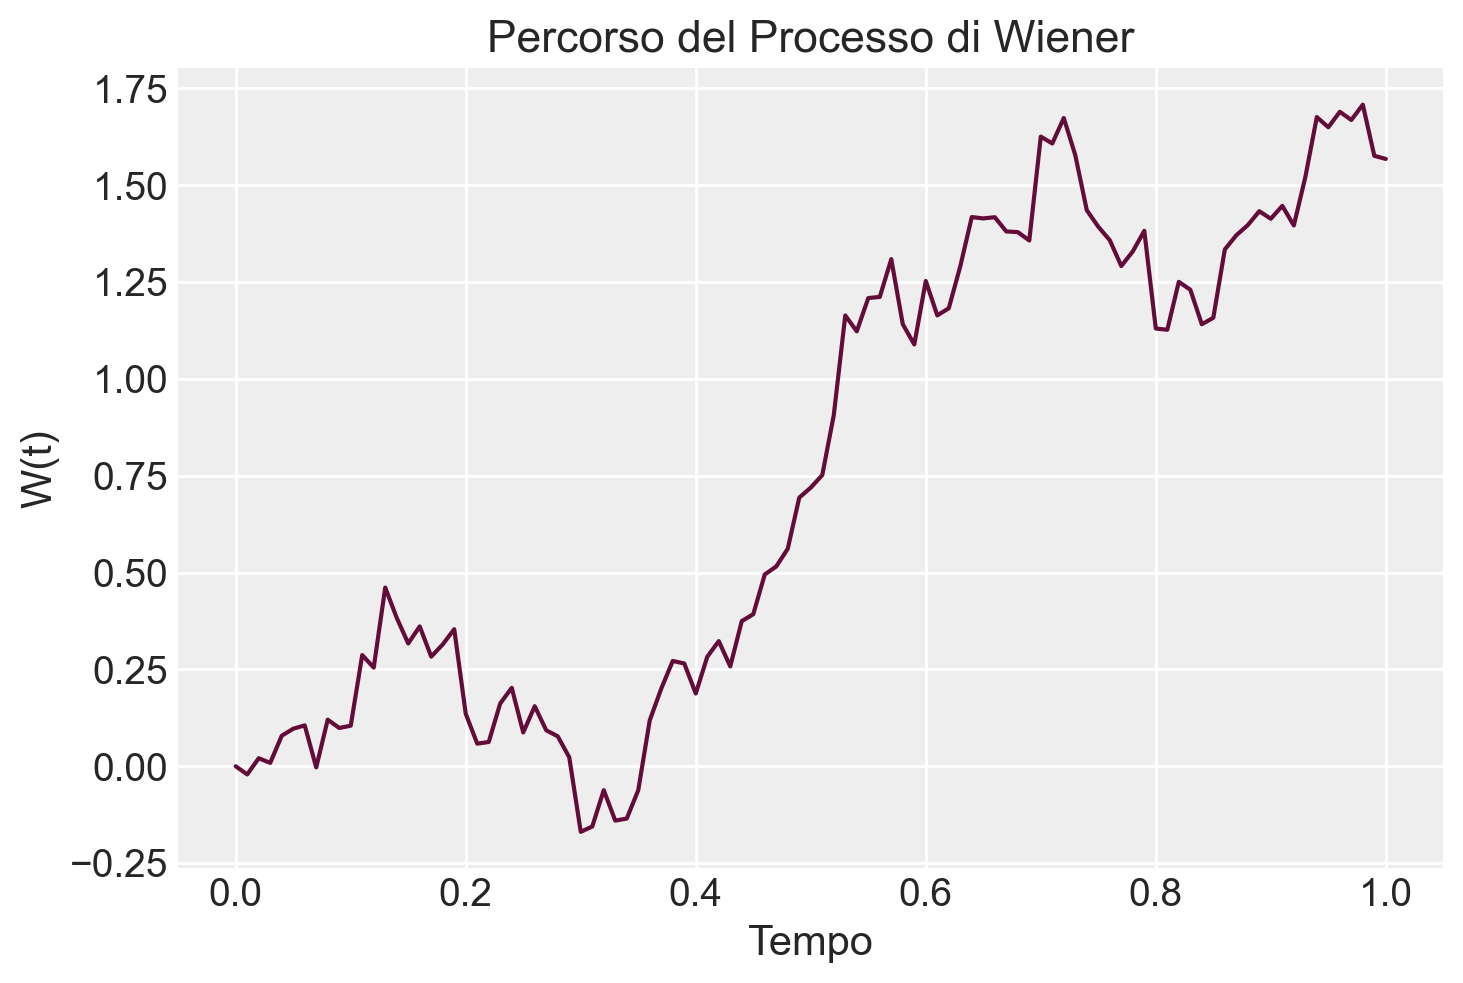

In [79]:
# Parametri
T = 1.0  # Tempo totale
dt = 0.01  # Passo temporale
N = int(T / dt)  # Numero di passi

# Simulazione del processo di Wiener
W = np.zeros(N + 1)
for i in range(1, N + 1):
    dW = np.random.normal(0, np.sqrt(dt))
    W[i] = W[i - 1] + dW

# Visualizzazione del percorso
plt.plot(np.linspace(0, T, N + 1), W)
plt.title("Percorso del Processo di Wiener")
plt.xlabel("Tempo")
plt.ylabel("W(t)")
plt.show()

:::

::: {#exm-}

Simulare più percorsi del processo di Wiener e verificare che la distribuzione finale sia normale con media 0 e varianza $T$.

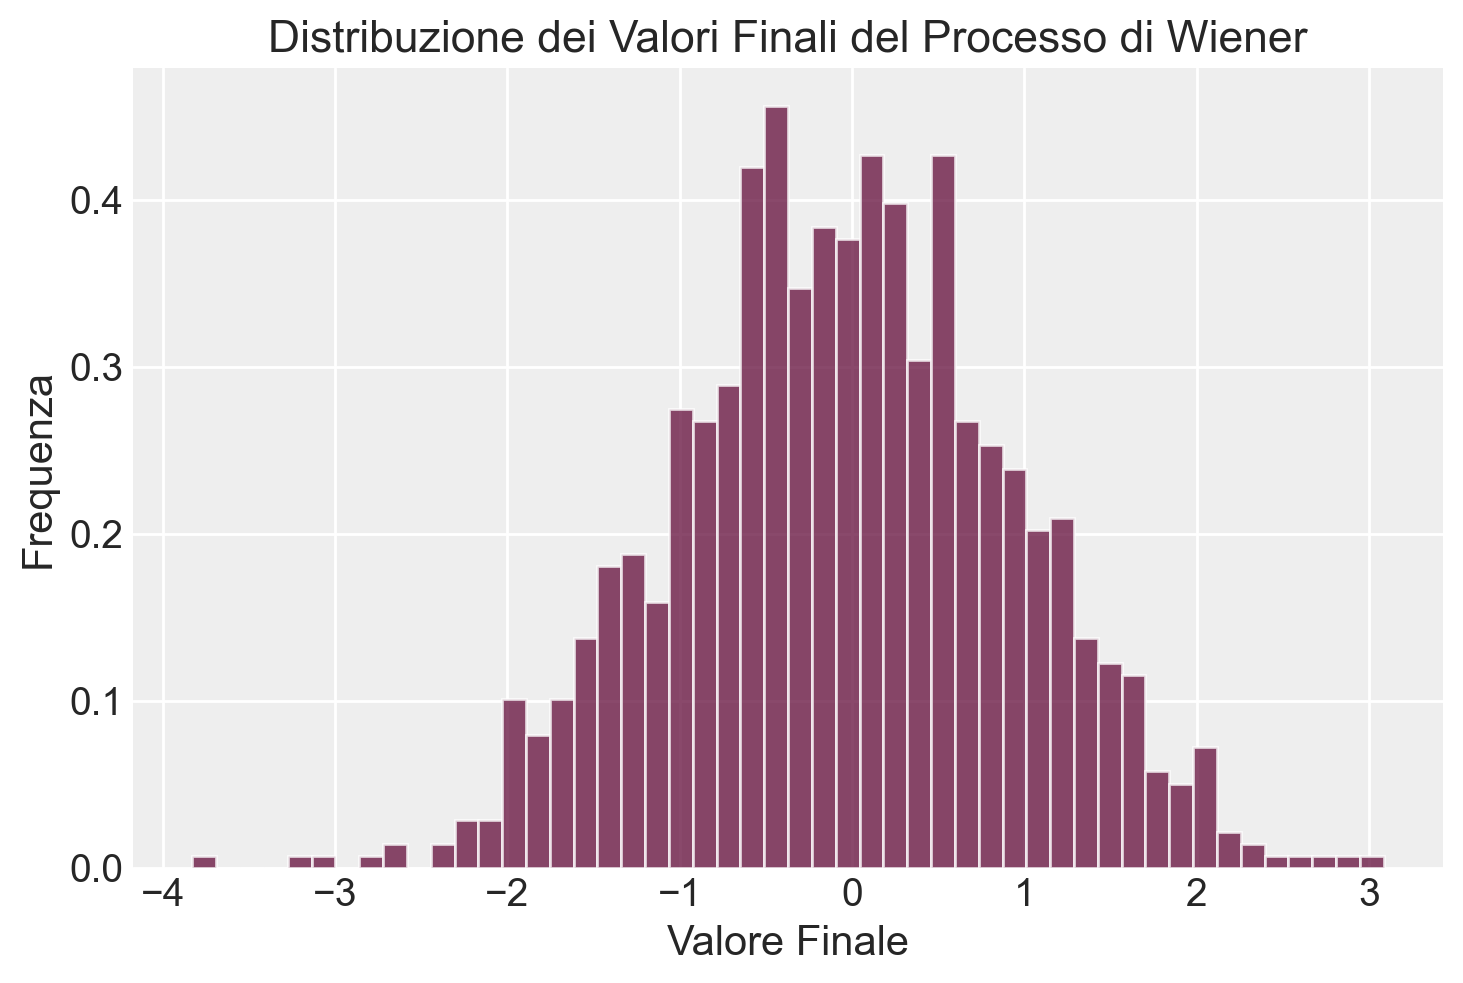

In [80]:
# Parametri
T = 1.0  # Tempo totale
dt = 0.01  # Passo temporale
N = int(T / dt)  # Numero di passi
num_simulations = 1000  # Numero di percorsi

# Simulazione del processo di Wiener
final_values = []
for _ in range(num_simulations):
    W = np.zeros(N + 1)
    for i in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        W[i] = W[i - 1] + dW
    final_values.append(W[-1])

# Visualizzazione della distribuzione finale
plt.hist(final_values, bins=50, density=True, alpha=0.75)
plt.title("Distribuzione dei Valori Finali del Processo di Wiener")
plt.xlabel("Valore Finale")
plt.ylabel("Frequenza")
plt.show()

::: 

::: {#exm-}

Studiare come cambia il percorso simulato del processo di Wiener al variare del passo temporale $dt$.

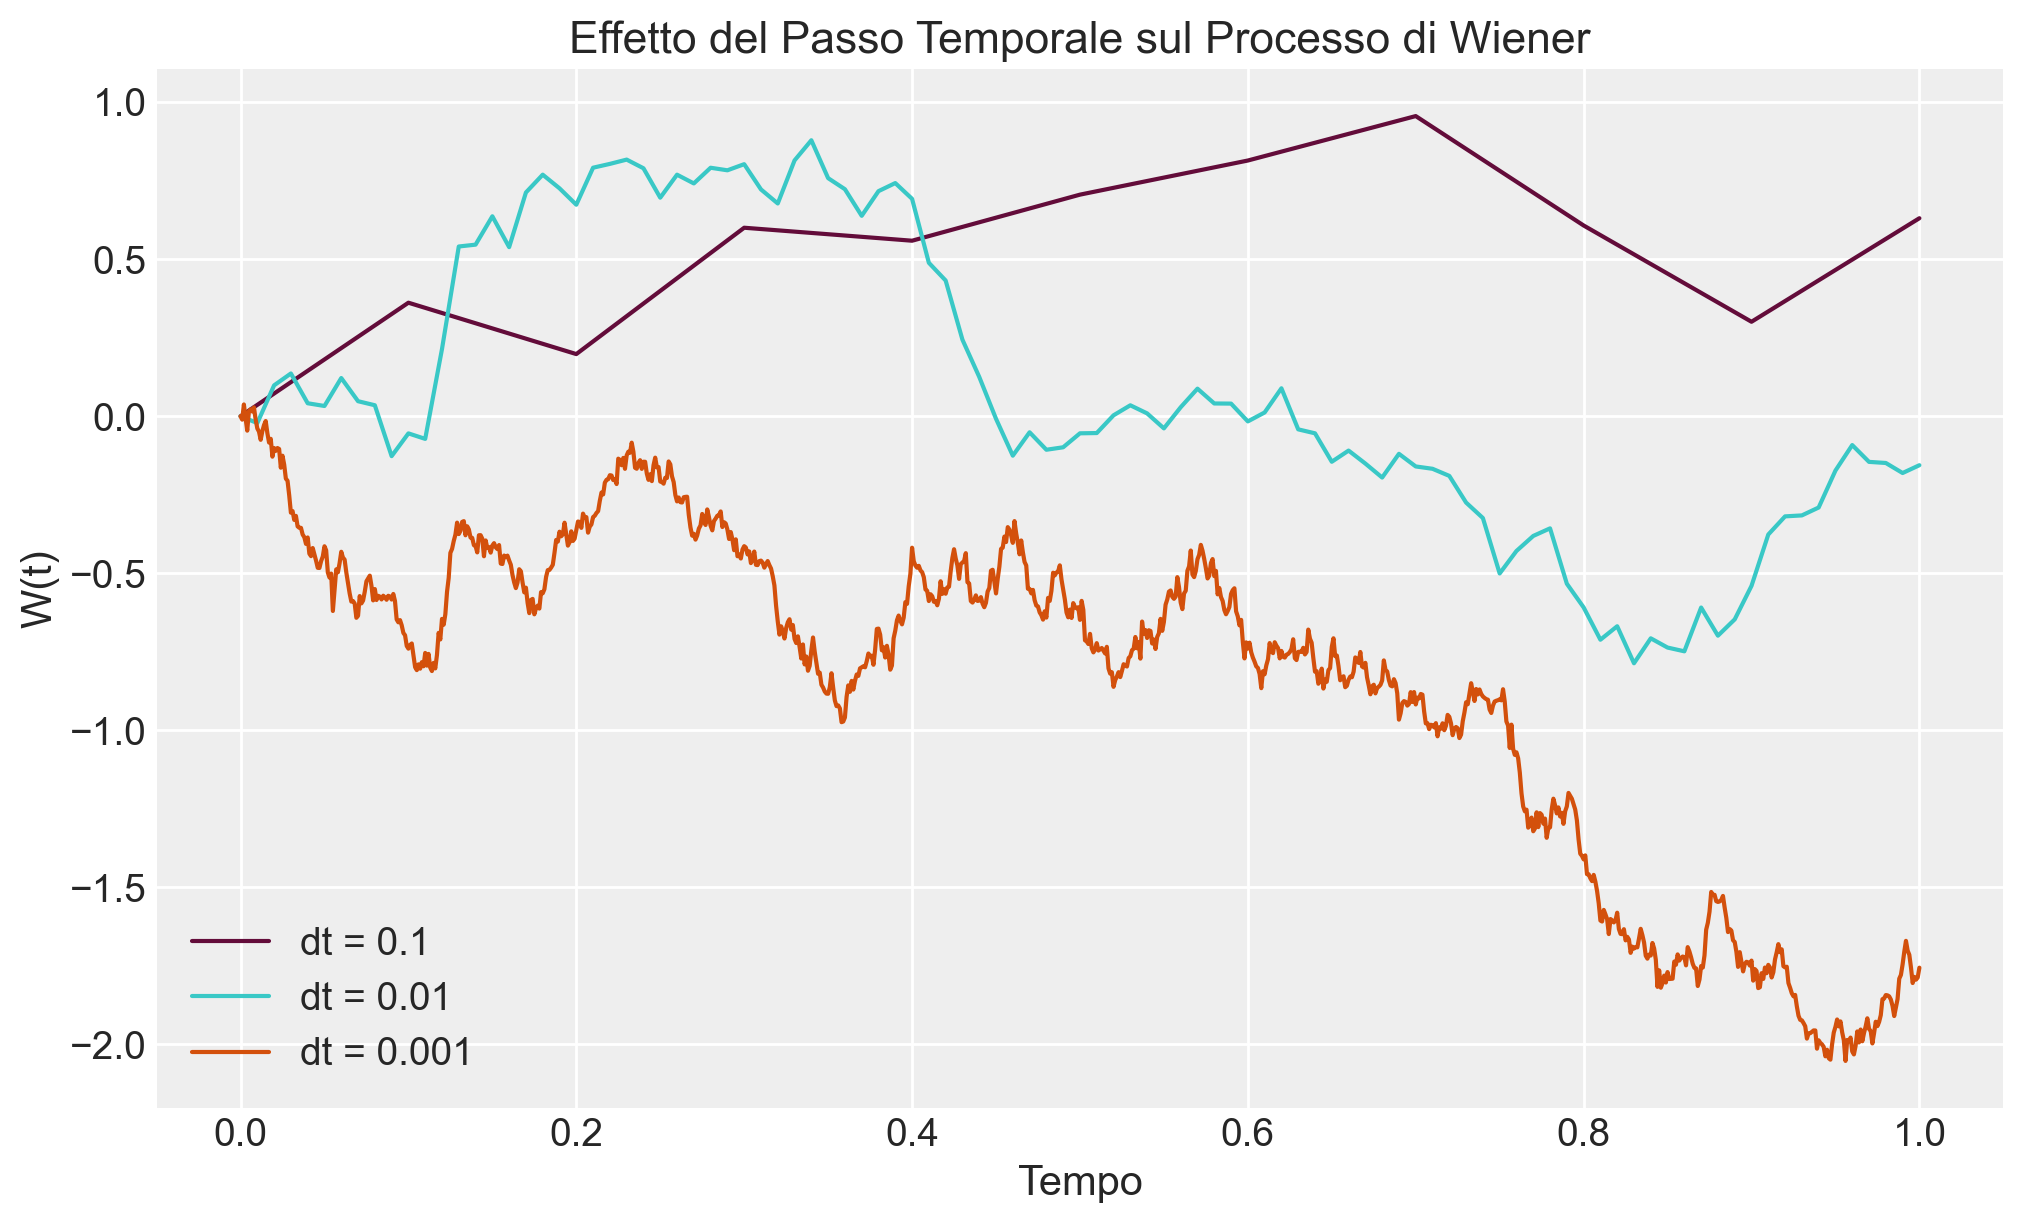

In [81]:
# Parametri
T = 1.0  # Tempo totale
dt_values = [0.1, 0.01, 0.001]  # Differenti passi temporali

plt.figure(figsize=(10, 6))

for dt in dt_values:
    N = int(T / dt)
    W = np.zeros(N + 1)
    for i in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        W[i] = W[i - 1] + dW
    plt.plot(np.linspace(0, T, N + 1), W, label=f"dt = {dt}")

plt.title("Effetto del Passo Temporale sul Processo di Wiener")
plt.xlabel("Tempo")
plt.ylabel("W(t)")
plt.legend()
plt.show()

:::

::: {#exm-}

Calcolare le statistiche (media, varianza) del processo di Wiener in vari momenti temporali e confrontarle con le aspettative teoriche.

In [82]:
# Parametri
T = 1.0  # Tempo totale
dt = 0.01  # Passo temporale
N = int(T / dt)  # Numero di passi
num_simulations = 1000  # Numero di percorsi
times = [0.2, 0.5, 1.0]  # Tempi da analizzare

# Simulazione del processo di Wiener
results = {time: [] for time in times}

for _ in range(num_simulations):
    W = np.zeros(N + 1)
    for i in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        W[i] = W[i - 1] + dW
    for time in times:
        index = int(time / dt)
        results[time].append(W[index])

# Calcolo delle statistiche e confronto con la teoria
for time in times:
    mean_empirical = np.mean(results[time])
    var_empirical = np.var(results[time])
    print(f"Tempo: {time}")
    print(f"Media empirica: {mean_empirical}, Media teorica: 0")
    print(f"Varianza empirica: {var_empirical}, Varianza teorica: {time}")
    print("-" * 40)

Tempo: 0.2
Media empirica: -0.01777872452188507, Media teorica: 0
Varianza empirica: 0.2053824073161039, Varianza teorica: 0.2
----------------------------------------
Tempo: 0.5
Media empirica: -0.005285999658711841, Media teorica: 0
Varianza empirica: 0.5293344499462272, Varianza teorica: 0.5
----------------------------------------
Tempo: 1.0
Media empirica: 0.008509695492746614, Media teorica: 0
Varianza empirica: 0.999542671263401, Varianza teorica: 1.0
----------------------------------------


::: 

::: {#exm-}

Simulare un processo di Wiener con un drift costante (valore di tendenza $\mu$) e osservare come il percorso viene influenzato.

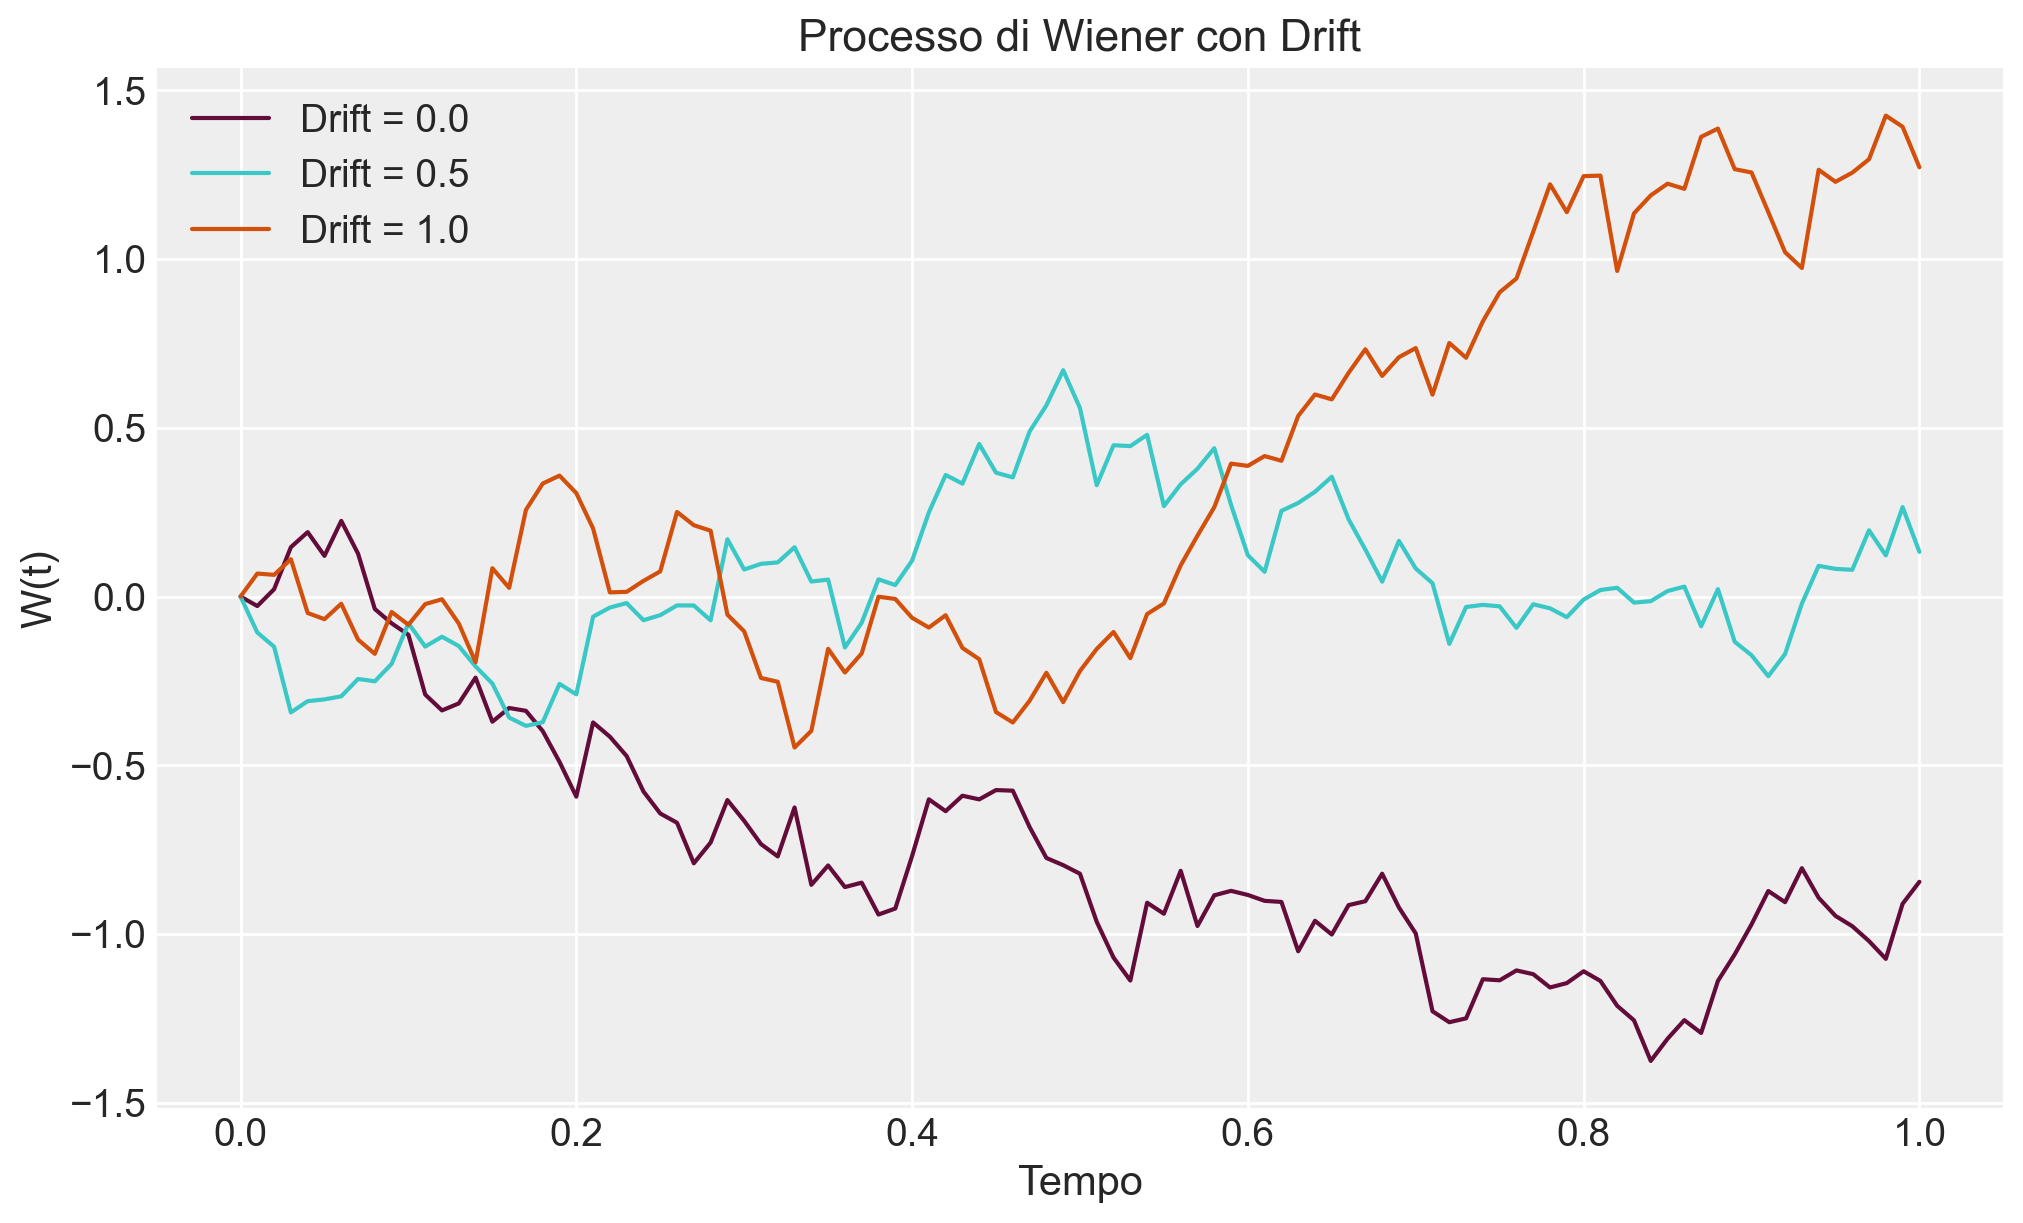

In [83]:
# Parametri
T = 1.0  # Tempo totale
dt = 0.01  # Passo temporale
N = int(T / dt)  # Numero di passi
drift_values = [0.0, 0.5, 1.0]  # Differenti valori di drift

plt.figure(figsize=(10, 6))

for drift in drift_values:
    W = np.zeros(N + 1)
    for i in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        W[i] = W[i - 1] + drift * dt + dW
    plt.plot(np.linspace(0, T, N + 1), W, label=f"Drift = {drift}")

plt.title("Processo di Wiener con Drift")
plt.xlabel("Tempo")
plt.ylabel("W(t)")
plt.legend()
plt.show()

:::

## Considerazioni Conclusive

Un modo per approfondire la comprensione della presa di decisione è attraverso l'utilizzo di *modelli computazionali*. Questi modelli cercano di dedurre informazioni sui processi cognitivi sottostanti a partire dai comportamenti osservabili durante il processo decisionale. Offrendo un quadro matematico per descrivere il comportamento, i modelli computazionali consentono ai ricercatori di svelare i meccanismi che guidano le azioni osservate. In questo capitolo, abbiamo esaminato il Drift Diffusion Model (DDM), che rappresenta l'accumulo di evidenze nel contesto di una decisione rapida tra due alternative, utilizzando quattro parametri: il drift rate, la threshold separation, il non-decision time e il starting point. Questi parametri sono considerati costanti nell'arco temporale in cui viene misurato il processo decisionale. Tuttavia, nelle versioni più recenti di questo modello [@schumacher2023neural], si ipotizza che anche questi parametri possano variare nel tempo.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Tue Aug 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

Watermark: 2.4.3

